# 第7章: 機械学習

本章では、[Stanford Sentiment Treebank (SST)](https://nlp.stanford.edu/sentiment/) データセットを用い、評判分析器（ポジネガ分類器）を構築する。ここでは処理を簡略化するため、[General Language Understanding Evaluation (GLUE)](https://gluebenchmark.com/) ベンチマークで配布されているSSTデータセットを用いる。


In [1]:
%%capture
!pip install scikit-learn
!pip install numpy
!wget https://dl.fbaipublicfiles.com/glue/data/SST-2.zip
!unzip SST-2.zip

## 60. データの入手・整形

GLUEのウェブサイトから[SST-2](https://dl.fbaipublicfiles.com/glue/data/SST-2.zip)データセットを取得せよ。学習データ（`train.tsv`）と検証データ（`dev.tsv`）のぞれぞれについて、ポジティブ (1) とネガティブ (0) の事例数をカウントせよ。

In [2]:
import pandas as pd

# データの読み込み
train_df = pd.read_csv("SST-2/train.tsv", sep='\t', )
dev_df = pd.read_csv("SST-2/dev.tsv", sep='\t', )

train_pos_count = (train_df["label"] == 1).sum()
train_neg_count = (train_df["label"] == 0).sum()
dev_pos_count = (dev_df["label"] == 1).sum()
dev_neg_count = (dev_df["label"] == 0).sum()

print("Train: Positive =", train_pos_count, ", Negative =", train_neg_count)
print("Valid: Positive =", dev_pos_count, ", Negative =", dev_neg_count)
train_df.head()

Train: Positive = 37569 , Negative = 29780
Valid: Positive = 444 , Negative = 428


,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0


## 61. 特徴ベクトル

Bag of Words (BoW) に基づき、学習データ（`train.tsv`）および検証データ（`dev.tsv`）のテキストを特徴ベクトルに変換したい。ここで、ある事例のテキストの特徴ベクトルは、テキスト中に含まれる単語（スペース区切りのトークン）の出現頻度で構成する。例えば、"too loud , too goofy"というテキストに対応する特徴ベクトルは、以下のような辞書オブジェクトで表現される。

```python
{'too': 2, 'loud': 1, ',': 1, 'goofy': 1}
```

各事例はテキスト、特徴ベクトル、ラベルを格納した辞書オブジェクトでまとめておく。例えば、先ほどの"too loud , too goofy"に対してラベル"0"（ネガティブ）が付与された事例は、以下のオブジェクトで表現される。

```python
{'text': 'too loud , too goofy', 'label': '0', 'feature': {'too': 2, 'loud': 1, ',': 1, 'goofy': 1}}
```

学習データと検証データの各事例を上記のような辞書オブジェクトに変換したうえで、学習データと検証データのそれぞれを、辞書オブジェクトのリストとして表現せよ。さらに、学習データの最初の事例について、正しく特徴ベクトルに変換できたか、目視で確認せよ。

In [3]:
from collections import Counter

def text2feature(text):
  return dict(Counter(text.split())) #split text and count word with counter


def apply_text2feature_to_df(df):
  '''
  sentenceカラムからsentence引っ張ってきてtext2feature関数を使用したのちその出力を
  新たに追加したfeatureカラムに格納する
  '''
  df['feature'] = df['sentence'].apply(text2feature)
  return df

train_df = apply_text2feature_to_df(train_df)
dev_df = apply_text2feature_to_df(dev_df)
dev_df.head()


,sentence,label,feature
0,it 's a charming and often affecting journey .,1,"{'it': 1, ''s': 1, 'a': 1, 'charming': 1, 'and..."
1,unflinchingly bleak and desperate,0,"{'unflinchingly': 1, 'bleak': 1, 'and': 1, 'de..."
2,allows us to hope that nolan is poised to emba...,1,"{'allows': 1, 'us': 1, 'to': 2, 'hope': 1, 'th..."
3,"the acting , costumes , music , cinematography...",1,"{'the': 2, 'acting': 1, ',': 3, 'costumes': 1,..."
4,"it 's slow -- very , very slow .",0,"{'it': 1, ''s': 1, 'slow': 2, '--': 1, 'very':..."


## 62. 学習

61で構築した学習データの特徴ベクトルを用いて、ロジスティック回帰モデルを学習せよ。

In [4]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()

train_data = vectorizer.fit_transform(train_df['feature'])

print(train_data) #テキストの数:67349, 語彙数:14

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 596119 stored elements and shape (67349, 14816)>
  Coords	Values
  (0, 5294)	1.0
  (0, 6138)	1.0
  (0, 8769)	1.0
  (0, 9369)	1.0
  (0, 11389)	1.0
  (0, 13131)	1.0
  (0, 13896)	1.0
  (1, 31)	1.0
  (1, 2800)	1.0
  (1, 5377)	1.0
  (1, 7354)	1.0
  (1, 8811)	1.0
  (1, 9065)	1.0
  (1, 14588)	1.0
  (2, 236)	1.0
  (2, 686)	1.0
  (2, 1263)	1.0
  (2, 2167)	1.0
  (2, 2601)	1.0
  (2, 6355)	1.0
  (2, 6998)	1.0
  (2, 7807)	1.0
  (2, 8690)	1.0
  (2, 10421)	1.0
  (2, 12106)	1.0
  :	:
  (67346, 6999)	1.0
  (67346, 8403)	1.0
  (67346, 11565)	1.0
  (67346, 13131)	1.0
  (67347, 210)	1.0
  (67347, 9439)	1.0
  (67347, 14156)	1.0
  (67348, 31)	1.0
  (67348, 34)	1.0
  (67348, 210)	1.0
  (67348, 686)	1.0
  (67348, 1242)	1.0
  (67348, 2809)	1.0
  (67348, 5134)	1.0
  (67348, 7034)	1.0
  (67348, 8098)	1.0
  (67348, 8602)	1.0
  (67348, 8769)	1.0
  (67348, 8823)	1.0
  (67348, 8989)	1.0
  (67348, 11541)	1.0
  (67348, 12619)	1.0
  (67348, 13131)	1.0
  (673

In [5]:
from sklearn.linear_model import LogisticRegression

X = train_data
y = train_df['label']

model = LogisticRegression(max_iter=1000)
model.fit(X, y)

LogisticRegression(max_iter=1000)

## 63. 予測

学習したロジスティック回帰モデルを用い、検証データの先頭の事例のラベル（ポジネガ）を予測せよ。また、予測されたラベルが検証データで付与されていたラベルと一致しているか、確認せよ。

In [6]:
dev_data = vectorizer.transform(dev_df['feature'])
dev_y = dev_df['label']

result = pd.DataFrame()
result['predict'] = model.predict(dev_data)
result['label'] = dev_y
result.head()

,predict,label
0,1,1
1,0,0
2,1,1
3,1,1
4,0,0


In [7]:
result = pd.concat([dev_df, result], axis=1)
result.head()

,sentence,label,feature,predict,label
0,it 's a charming and often affecting journey .,1,"{'it': 1, ''s': 1, 'a': 1, 'charming': 1, 'and...",1,1
1,unflinchingly bleak and desperate,0,"{'unflinchingly': 1, 'bleak': 1, 'and': 1, 'de...",0,0
2,allows us to hope that nolan is poised to emba...,1,"{'allows': 1, 'us': 1, 'to': 2, 'hope': 1, 'th...",1,1
3,"the acting , costumes , music , cinematography...",1,"{'the': 2, 'acting': 1, ',': 3, 'costumes': 1,...",1,1
4,"it 's slow -- very , very slow .",0,"{'it': 1, ''s': 1, 'slow': 2, '--': 1, 'very':...",0,0


## 64. 条件付き確率

学習したロジスティック回帰モデルを用い、検証データの先頭の事例を各ラベル（ポジネガ）に分類するときの条件付き確率を求めよ。

In [8]:
proba = model.predict_proba(dev_data[:1])
print(f"P(positive|sentence1) = {proba[0][1]}")
print(f"P(negative|sentence1) = {proba[0][0]}")

P(positive|sentence1) = 0.9957220070981616
P(negative|sentence1) = 0.00427799290183839


## 65. テキストのポジネガの予測

与えられたテキストのポジネガを予測するプログラムを実装せよ。例えば、テキストとして"the worst movie I 've ever seen"を与え、ロジスティック回帰モデルの予測結果を確認せよ。


In [9]:
def negpos_predict(text,model):
  #テキストを入力として
  text_feature = text2feature(text)
  text_data = vectorizer.transform([text_feature])
  return model.predict(text_data)


negpos_predict("the worst movie I 've ever seen", model)

array([0])

## 66. 混同行列の作成

学習したロジスティック回帰モデルの検証データにおける混同行列（confusion matrix）を求めよ。

In [10]:
import pandas as pd
from sklearn.metrics import confusion_matrix

y_pred = model.predict(dev_data)
y_true = dev_y

cm = confusion_matrix(y_true, y_pred)

classes = model.classes_

cm_df = pd.DataFrame(
    cm,
    index=[f"Actual:{c}" for c in classes],
    columns=[f"Pred:{c}" for c in classes]
)

# 混合行列の中身
#        pred: 0    pred: 1
# actual
#   0      TN         FP
#   1      FN         TP

print(cm_df)


          Pred:0  Pred:1
Actual:0     334      94
Actual:1      73     371


## 67. 精度の計測

学習したロジスティック回帰モデルの正解率、適合率、再現率、F1スコアを、学習データおよび検証データ上で計測せよ。

In [11]:
accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
precision = cm[1][1] / (cm[0][1] + cm[1][1])
recall = cm[1][1] / (cm[1][0] + cm[1][1])
f1_score = 2 * ((precision * recall) / (precision + recall))

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 0.8085
Precision: 0.7978
Recall: 0.8356
F1 Score: 0.8163


## 68. 特徴量の重みの確認

学習したロジスティック回帰モデルの中で、重みの高い特徴量トップ20と、重みの低い特徴量トップ20を確認せよ。

In [12]:
import pandas as pd
import numpy as np


feature_names = vectorizer.get_feature_names_out()

coefs = model.coef_[0]

coef_df = pd.DataFrame({
    'feature': feature_names,
    'weight': coefs
})

top_20 = coef_df.sort_values(by='weight', ascending=False).head(20)

bottom_20 = coef_df.sort_values(by='weight', ascending=True).head(20)

print("Top 20 Positive Features:")
print(top_20)

print("\nTop 20 Negative Features:")
print(bottom_20)

Top 20 Positive Features:
           feature    weight
10593   refreshing  3.413905
10675   remarkable  3.401332
9915      powerful  3.209044
6169     hilarious  3.164218
1263     beautiful  2.993045
14622    wonderful  2.961129
10145        prose  2.891201
788      appealing  2.848768
13103     terrific  2.845935
13492        treat  2.791234
4321     enjoyable  2.780471
2180       charmer  2.748543
14212      vividly  2.707208
7627       likable  2.674239
2181      charming  2.645338
12089        solid  2.644748
4802   fascinating  2.616087
5877      half-bad  2.592260
6574    impressive  2.587231
6901    intriguing  2.576110

Top 20 Negative Features:
             feature    weight
7365         lacking -4.323334
7367           lacks -4.056426
14674          worst -4.000704
3543          devoid -3.639067
8216            mess -3.585644
4729         failure -3.547112
12618         stupid -3.327829
1615            bore -3.238688
5021            flat -3.221390
3456      depressing -3.1709

## 69. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき、正則化の係数（ハイパーパラメータ）を調整することで、学習時の適合度合いを制御できる。正則化の係数を変化させながらロジスティック回帰モデルを学習し、検証データ上の正解率を求めよ。実験の結果は、正則化パラメータを横軸、正解率を縦軸としたグラフにまとめよ。

In [13]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def LogisticRegression_with_C(train_x, train_y, dev_x, dev_y, C):
    lg = LogisticRegression(C=C, max_iter=1000)#学習アルゴリズムの最大実行回数を決めといた
    lg.fit(train_x, train_y)
    y_pred = lg.predict(dev_x)
    return accuracy_score(dev_y, y_pred)

C_values = np.logspace(-5, 5, 11)
accuracy_list = []

for C in C_values:
    accuracy = LogisticRegression_with_C(train_data, train_df['label'], dev_data, dev_df['label'], C)
    accuracy_list.append(accuracy)

print("C values:", C_values)
print("Accuracies:", accuracy_list)


C values: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05]
Accuracies: [0.5091743119266054, 0.5206422018348624, 0.6811926605504587, 0.7545871559633027, 0.8004587155963303, 0.8084862385321101, 0.8222477064220184, 0.7958715596330275, 0.7901376146788991, 0.7844036697247706, 0.7889908256880734]


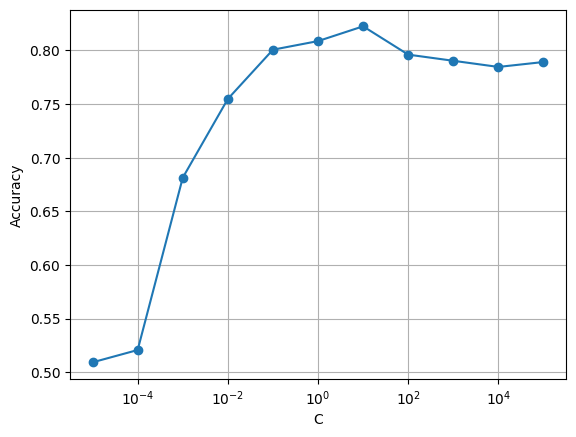

In [14]:
import matplotlib.pyplot as plt

plt.semilogx(C_values, accuracy_list, marker='o')
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()